# Entornos y Trayectorias

El objetivo de esta práctica es estudiar el funcionamiento de los Algoritmos de Búsqueda Aleatoria, Local, Enfriamiento Simulado y Búsqueda Tabú.

El comportamiento de los algoritmos de OCH implementados deberá compararse con un Algoritmo Greedy

Este algoritmo debe maximizar los ingresos diarios para una instalación de planta solar que tiene una capacidad total de 1000 m2 con un rendimiento del 20% de la energía recibida. La planta posee una batería que puede almacenar energía antes de venderse de 300 kWh de capacidad.

Recibirás el día anterior una previsión meteorológica con la radiación por hora en un vector R (24 enteros
con w por m2) y el precio previsto de la energía cada hora en P (24 valores reales en euros por cada kWh)

El algoritmo debe decidir que decidir por cada hora cuánta energía se venderá / comprará, la energía que se produce cada hora (o compra) y no se vende se almacena en la batería (que tiene un límite de 300kwh y comienza vacía todos los días). Toda la energía que no almacena ni vende se desperdicia.

Precio por día por kWh: a continuación, se muestran los precios reales para el día de hoy en la península, genera una lista de valores a mano deduciéndolos de la grafica en una variable o en un fichero con los valores en céntimos de euro por horas (24 valores).

Asume estos valores como precios de venta de los kWh producidos en planta.

## Librerías

In [1]:
import random
import math

# Graphs and Plots
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

import statistics

import pandas as pd

import time

import os

## Parámetros

### Semillas

In [2]:
# Establecer semillas

semilla_1 = 12345
semilla_2 = 78910
semilla_3 = 13579
semilla_4 = 246810
semilla_5 = 3656827

semillas = [semilla_1, semilla_2, semilla_3, semilla_4, semilla_5]

### Precio

Precio de compra y precio de venta forman el array de 2 filas precio donde:
- precio[0] corresponde al precio_compra
- precio[1] corresponda al precio_venta

El precio se expresa en cents/kWh

In [3]:
# precio[0] = precios de compra
precio_compra_problema1 = [26, 26, 25, 24,23,24,25,27,30,29,34,32,31,31,25,24,25,26,34,36,39,40,38,29]
precio_compra_problema2= [7,7,50,25,11,26,48,45,10,14,42,14,42,22,40,34,21,31,29,34,11,37,8,50]

# precio[1] = precios de venta
precio_venta_problema1 = [24, 23, 22, 23,22,22,20,20,20,19,19,20,19,20,22,23,22,23,26,28,34,35,34,24] # 21 = max
precio_venta_problema2= [1,3,21,1,10,7,44,35,4,1,23,12,30,7,30,4,9,10,6,9,8,27,7,10]

precio_problema1 = [precio_compra_problema1, precio_venta_problema1]
precio_problema2 = [precio_compra_problema2, precio_venta_problema2]

precio = precio_problema1

### Radiacion
Radiacion en Wh/m2

In [4]:
# radiacion W/h en m2
radiacion_problema1 = [0, 0, 0, 0, 0, 0, 0, 0, 100, 313, 500, 661, 786, 419, 865, 230, 239, 715, 634, 468, 285, 96, 0, 0]
radiacion_problema2 = [274, 345, 605, 810, 252, 56, 964, 98, 77, 816, 68, 261, 841, 897, 75, 489, 833, 96, 117, 956, 970, 255, 74, 926]
radiacion = radiacion_problema1

### Horas

In [5]:
horas = [0] * 24
for idx, hora in enumerate(horas):
    horas[idx] = idx

### Constantes

In [6]:
superficie = 1000   # m2
ganancia = 0.2  # 20%
bateria_maxima = 300 # kw                           # * 1000     # kW * 1000 = W

#### Algoritmos

In [7]:
greedy_name = "Greedy"
busqueda_aleatoria_name = "Búsqueda Aleatoria"
mejor_name = "El Mejor"
primero_mejor_name = "Primero El Mejor"
busqueda_local_vnd_name = "Búsqueda Local VND"
enfriamiento_simulado_name = "Simulated Annealing"
busqueda_tabu_name = "Búsqueda Tabú"

### Resultados

In [8]:
Data = []
Algorithms_names = []

El resultado esperado es la cantidad en euros conseguida en el día, calculada como el precio por kWh vendidos en esa Hora. Dado que lo que podamos vender dependerá de la carga de la batería en dicho momento no se puede saber de antemano el resultado, por lo que el resultado será calculado mediante una simulación usando los precios y radiación. La simulación interpretará las instrucciones en la solución actual a evaluar calculando cada hora la carga de la batería y la cantidad en euros, que puede ser negativa.

## Funciones auxiliares

### Conversiones de parametros

#### Energia

In [9]:
def kw_to_w(energia_kw):
    '''
    kwh a wh
    '''

    return energia_kw * 1000

def w_to_kw(energia_w):
    '''
    w a kw
    '''

    return energia_w / 1000

In [10]:
def energia_a_porcentaje(energia):
    """
    :param energia: energia en kW
    :return porcentaje_bateria: equivalente de esos kW en porcentaje de la bateria
    """

    porcentaje_bateria = (energia / bateria_maxima) * 100

    return porcentaje_bateria


def porcentaje_a_energia(porcentaje):
    """
    :param porcentaje: equivalente de esos kW en porcentaje de la bateria
    :return energia: energia en kW
    """

    energia = (porcentaje * bateria_maxima) / 100

    return energia

#### Dinero

In [11]:
def cents_to_euros(cents):
    '''
    cents to euros
    '''

    return cents / 100

def euros_to_cents(euros):
    '''
    euro to cents
    '''

    return euros * 100

### Representación gráfica

In [12]:
def representar_grafica(dinero_hora, bateria_hora, precios_venta = precio_venta_problema1, precios_compra = precio_compra_problema1, img_name = ""):
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    dinero = host.twinx()
    bateria = host.twinx()

    offset = 5

    '''new_fixed_axis = dinero.get_grid_helper().new_fixed_axis
    dinero.axis["left"] = new_fixed_axis(loc="left", axes=dinero,
                                            offset=(0, 0))'''

    new_fixed_axis = bateria.get_grid_helper().new_fixed_axis
    bateria.axis["right"] = new_fixed_axis(loc="right", axes=bateria,
                                            offset=(offset, 0))

    host.set_xlabel("Horas")
    # host.set_ylabel("Dinero (€)")
    dinero.set_ylabel("Dinero (€)")
    bateria.set_ylabel("Bateria (%)")

    # host.set_xlim(0, 23)
    #host.set_ylim(0, 400)



    # bateria.set(ylim=(0,100))
    dinero.set(ylim=(min(dinero_hora),max(dinero_hora)))



    # Dinero acumulado en cada hora
    host.plot(horas,
             dinero_hora,
             linewidth=3,
             color='yellow',
             alpha=0.5)

    # Capacidad de la bateria en cada hora
    bat, = bateria.plot(horas,
             bateria_hora,
             color='green',
             alpha=0.8)

    # coeficiente_representacion = 1
    # Precio por hora
    dinero.plot(horas,    # eje x
             precios_venta, #[p * coeficiente_representacion for p in precios_venta],
             color='blue')

    # coeficiente_representacion = 1
    # Precio por hora
    dinero.plot(horas,    # eje x
             precios_compra, #[p * coeficiente_representacion for p in precios_venta],
             color='red')

    host.legend(["Dinero Acumulado",  "Precios de venta", "Precios de compra", "Batería"])

    bateria.axis["right"].label.set_color(bat.get_color())

    if img_name:
        plt.text(1, 13, round(dinero_hora[len(dinero_hora)-1], 2), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        plt.title(img_name)

        if not os.path.exists(img_name.split(" (")[0]):
            os.makedirs(img_name.split(" (")[0])

        plt.savefig(img_name.split(" (")[0] + "/" + img_name + ".png", dpi=300, bbox_inches='tight')

    plt.show()

    return plt

In [13]:
def representar_grafica_greedy(dinero_hora, bateria_hora, hora_venta_pico, precios_venta, img_name = ""):
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    dinero = host.twinx()
    bateria = host.twinx()

    offset = 5

    '''new_fixed_axis = dinero.get_grid_helper().new_fixed_axis
    dinero.axis["left"] = new_fixed_axis(loc="left", axes=dinero,
                                            offset=(0, 0))'''

    new_fixed_axis = bateria.get_grid_helper().new_fixed_axis
    bateria.axis["right"] = new_fixed_axis(loc="right", axes=bateria,
                                            offset=(offset, 0))

    host.set_xlabel("Horas")
    # host.set_ylabel("Dinero (€)")
    dinero.set_ylabel("Dinero (€)")
    bateria.set_ylabel("Bateria (%)")

    # host.set_xlim(0, 23)
    #host.set_ylim(0, 400)



    # bateria.set(ylim=(0,100))
    dinero.set(ylim=(min(dinero_hora),max(dinero_hora)))



    # Dinero acumulado en cada hora
    host.plot(horas,
             dinero_hora,
             linewidth=3,
             color='yellow',
             alpha=0.5)

    # Capacidad de la bateria en cada hora
    bat, = bateria.plot(horas,
             bateria_hora,
             color='green',
             alpha=0.8)

    # Linea de hora de venta
    # poner variable hora_venta_pico, para cuando meta el generar grafica dentro de una funcion
    dinero.plot([hora_venta_pico for _ in [0, round(max(dinero_hora))]],
             [i for i in [0, round(max(dinero_hora))]],
             linestyle=':',
             color='red')

    # coeficiente_representacion = 1
    # Precio por hora
    dinero.plot(horas,    # eje x
             precios_venta, #[p * coeficiente_representacion for p in precios_venta],
             color='blue')

    host.legend(["Dinero Acumulado", "Hora de Venta (Pico)",  "Precios de venta", "Batería"])

    bateria.axis["right"].label.set_color(bat.get_color())

    if img_name:
        # plt.text(3, 7, dinero_hora[len(dinero_hora)-1], fontsize = 15)
        plt.text(1, 13, dinero_hora[len(dinero_hora)-1], style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        plt.title(img_name)

        if not os.path.exists(img_name):
            os.makedirs(img_name)

        plt.savefig(img_name + "/" + img_name + ".png", dpi=300, bbox_inches='tight')

    plt.show()
    #fig = plt.figure()
    # return fig

### Otras

In [14]:
def flatten(l):
    return [item for sublist in l for item in sublist]

Los valores que queremos obtener son:
Evaluaciones = numero medio de evaluaciones realizada por el algoritmo en las cinco ejecuciones
- Evaluación media (tiempo)
- Evaluación mejor (tiempo)
- Evaluación Desviación (tiempo)
- Mejor €
- Media €
- Desviación €

## Funciones auxiliares comunes a los algoritmos

### Generar Solución Inicial

In [15]:
def solucion_inicial():
    # implementación de la generación de solución inicial
    solucion = [0] * 24 # Inicializar el vector con 24 ceros

    # Generar una solución válida
    for hora in range(0,24):

        numero_aleatorio = random.randint(-100,100) # Generar un num aleatorio entre el -100 y 100

        assert -100 <= numero_aleatorio <= 100, "Un numero no está en los limites"

        solucion[hora] = numero_aleatorio

    return solucion

### Función Evaluación

In [16]:
def funcion_evaluacion(solucion, radiacion = radiacion, precio = precio, representar = False, img_name = ""):
    bateria_capacidad_porcentaje = 0
    dinero_total = 0

    hora_venta_pico = precio[1].index(max(precio[1]))

    # para la representacion de las funciones
    dinero_hora = [0 for _ in range(24)]
    bateria_hora = [0 for _ in range(24)]
    precios_venta = [0 for _ in range(24)]
    precios_compra = [0 for _ in range(24)]

    for hora in horas:

        # 1. Almacenar nueva energia
        energia_recibida = w_to_kw(radiacion[hora]) * superficie * ganancia  # a kwh
        bateria_capacidad_porcentaje += energia_a_porcentaje(energia_recibida)    # incrementar % de la bateria


        precio_venta_actual = precio[1][hora]
        precio_compra_actual = precio[0][hora]
        precios_venta[hora] = precio_venta_actual
        precios_compra[hora] = precio_compra_actual

        # 2. Vender si hay sobrante
        if bateria_capacidad_porcentaje > 100:
            porcentaje_bateria_sobrante = bateria_capacidad_porcentaje - 100
            bateria_capacidad_porcentaje = 100
            dinero_total += cents_to_euros((porcentaje_a_energia(porcentaje_bateria_sobrante)) * precio_venta_actual)

        # assert 0 <= bateria_capacidad_porcentaje <= 100, "Batería fuera de los posibles limites"
        assert -100 <= solucion[hora] <= 100, "Solucion hora fuera de los limites: " + str(solucion[hora])

        if solucion[hora] >= 0:  # Compra el porcentaje de batería introducido respecto a la fracción de almacenaje disponible, después de introducir la energía recibida en esa hora. Al hacer la compra sobre el porcentaje de energía almacenada tras añadir la nueva energía, solo se superará la capacidad de la batería con la nueva energía a almacenar, en este caso, esa energía sobrante se venderá.

            # 3. Comprar energia
            bateria_almacenable_porcentaje = 100 - bateria_capacidad_porcentaje # todo no puese ser menor de 0
            bateria_almacenar_porcentaje = (solucion[hora]) * bateria_almacenable_porcentaje / 100
            bateria_capacidad_porcentaje += bateria_almacenar_porcentaje

            if bateria_capacidad_porcentaje > 100:
                bateria_capacidad_porcentaje = round(bateria_capacidad_porcentaje)

            assert 0 <= bateria_capacidad_porcentaje <= 100, "Batería fuera de los posibles limites al comprar: " + str(bateria_capacidad_porcentaje)

            dinero_total -= cents_to_euros(porcentaje_a_energia(bateria_almacenar_porcentaje) * precio_compra_actual)

        else: # Vende el porcentaje de energía almacenada introducido.
            # 3. Vende energia

            bateria_vender_porcentaje = (abs(solucion[hora]) * bateria_capacidad_porcentaje) / 100

            bateria_capacidad_porcentaje -= bateria_vender_porcentaje

            if bateria_capacidad_porcentaje < 0: # pasa con numeros decimales muy pequeños por el redondeo
                bateria_capacidad_porcentaje = round(bateria_capacidad_porcentaje)

            assert 0 <= bateria_capacidad_porcentaje <= 100, "Batería fuera de los posibles limites, al vender: " + str(bateria_capacidad_porcentaje)

            dinero_total += cents_to_euros((porcentaje_a_energia(bateria_vender_porcentaje)) * precio_venta_actual)

        # si es la ultima hora vender todo:
        if hora == (len(horas) - 1):
            bateria_vender_porcentaje = 100 * bateria_capacidad_porcentaje / 100

            bateria_capacidad_porcentaje -= bateria_vender_porcentaje

            dinero_total += cents_to_euros((porcentaje_a_energia(bateria_vender_porcentaje)) * precio_venta_actual)

            assert int(bateria_capacidad_porcentaje) == 0, "La batería no se ha vaciado completamente al terminar el día: " + str(bateria_capacidad_porcentaje)

        bateria_hora[hora] = bateria_capacidad_porcentaje
        dinero_hora[hora] = dinero_total

    if representar:
        representar_grafica(dinero_hora, bateria_hora, precios_venta, precios_compra, img_name)

    return dinero_total

### Movimiento

In [17]:
# se genera un numero de vecinos, por ej 40 -> elegir una posicion y hacer + / - granularidad de esa posicion, yendo de 1 en 1 o de 10 en 10
# Función para generar vecino
def generador_vecino(solucion_actual, n_vecinos = 1, granularidad = 10):
    # implementación de la generación de vecino
    vecinos = []

    for _ in [n_vecinos]:

        vecino = solucion_actual.copy()

        # incremento
        for idx, elemento in enumerate(range(len(vecino))):
            nuevo_vecino = vecino.copy()
            nuevo_valor = vecino[idx] + granularidad
            nuevo_vecino[idx] = nuevo_valor

            # Se comprueba que el número resultante esté dentro del rango [-100, 100]
            # vecino[idx] = max(min(vecino[idx], 100), -100)

            #Para evitar que pueda haber valores por encima de 100 (porque es suma), si es +100 -> no appendiza el valor
            if nuevo_vecino[idx] <= 100:
                vecinos.append(nuevo_vecino)
                assert -100 <= nuevo_vecino[idx] <= 100, "Vecino fuera de los limites: " + str(nuevo_vecino[idx])

        # decremento
        for idx, elemento in enumerate(range(len(vecino))):
            nuevo_vecino = vecino.copy()
            nuevo_valor = vecino[idx] - granularidad
            nuevo_vecino[idx] = nuevo_valor

            # Se comprueba que el número resultante esté dentro del rango [-100, 100]
            # vecino[idx] = max(min(vecino[idx], 100), -100)
            # vecinos.append(vecino)

            #Para evitar que pueda haber valores por debajo de -100 (porque es resta), si es -100 -> no appendiza el valor
            if nuevo_vecino[idx] >= -100:
                vecinos.append(nuevo_vecino)
                assert -100 <= nuevo_vecino[idx] <= 100, "Vecino fuera de los limites: " + str(nuevo_vecino[idx])

        # vecinos.append(vecino)

    return vecinos

### Función auxiliar de evaluación

In [18]:
def evaluar_algoritmo(algorithm_name, parametros = []):
    Header = ["Ev. Medias", "Ev. Mejor", "Ev. Desviación", "Mejor €", "Media €", "Desviación €", "Ev. Mejor Dinero"]

    Ev = []
    Dinero = []

    Data = []

    for semilla in semillas:
        random.seed(semilla)

        if algorithm_name == greedy_name:
            contador_evaluaciones = 1
            totales_dineros = greedy()

            # assert contador_evaluaciones == len([totales_dineros]), "El número de evaluaciones no coincide con el número de resultados"

            # Ev.
            Ev.append(contador_evaluaciones)
            # €
            Dinero.append(totales_dineros)

            break

        elif algorithm_name == busqueda_aleatoria_name:
            solucion, contador_evaluaciones, totales_dineros = busqueda_aleatoria(parametros)
        elif algorithm_name == mejor_name:
            solucion, contador_evaluaciones, totales_dineros = busqueda_local_mejor(parametros[0])
        elif algorithm_name == primero_mejor_name:
            solucion, contador_evaluaciones, totales_dineros = busqueda_local_primero_mejor(parametros[0], parametros[1])
        elif algorithm_name == busqueda_local_vnd_name:
            solucion, contador_evaluaciones, totales_dineros = busqueda_local_vnd()
        elif algorithm_name == enfriamiento_simulado_name:
            solucion, contador_evaluaciones, totales_dineros = simulated_annealing(parametros[0], parametros[1], parametros[2])
        elif algorithm_name == busqueda_tabu_name:
            solucion, contador_evaluaciones, totales_dineros = busqueda_tabu(parametros[0])
        else:
            solucion, contador_evaluaciones, totales_dineros = busqueda_aleatoria(parametros)
            print("Se ha ejecutado el predeterminado: Búsqueda Aleatoria")

        img_name = str(algorithm_name + " (Semilla " + str(semilla) + ")")

        funcion_evaluacion(solucion, representar=True, img_name=img_name)

        # print("Dinero total: " + str(dinero_total))

        # print(contador_evaluaciones[0], len(totales_dineros))

        # assert contador_evaluaciones[0] == len(totales_dineros), "El número de evaluaciones (" + str(contador_evaluaciones[0]) + ") no coincide con el número de resultados (" + str(len(totales_dineros)) + ")"

        # Ev.
        Ev.append(contador_evaluaciones)
        # €
        Dinero.append(totales_dineros)

    # print(Ev)

    if algorithm_name == greedy_name:
        # Ev. Medias
        Data.append(1)
        #Data.append(contador_evaluaciones)
        # "Ev. Mejor"
        Data.append(1)
        # "Ev. Desviación"
        Data.append(0)
        # "Mejor €"
        Data.append(max(Dinero))
        # "Media €"
        Data.append(max(Dinero))
        # "Desviación €"
        Data.append(0)
        # "Ev. Mejor Dinero"
        # "Ev. Mejor"
        Data.append(Dinero.index(max(Dinero)) + 1)

    else:
        Ev = flatten(Ev)
        Dinero_flat = flatten(Dinero)

        inicio = 0
        fin = inicio
        lista_idx_dinero_max = []
        lista_dinero_max = []

        for idx, semilla in enumerate(semillas):
            inicio = fin
            fin = fin + Ev[idx]

            dinero_iteracion_actual = Dinero[idx]

            idx_max_dinero_iteracion_actual = dinero_iteracion_actual.index(max(dinero_iteracion_actual))
            lista_dinero_max.append(max(dinero_iteracion_actual))
            lista_idx_dinero_max.append(idx_max_dinero_iteracion_actual)

        # print(Ev)
        # print(lista_dinero_max)


        # 0 Ev. Medias
        Data.append(statistics.median(Ev))
        #Data.append(contador_evaluaciones)

        # 1 "Ev. Mejor" -> mide la covergencia
        # Data.append(Dinero.index(max(Dinero)))
        Data.append(min(Ev))

        # 2 "Ev. Desviación" -> mide la robustez, a mayor cercania a 0 mayor robustez
        # Data.append(statistics.stdev(Ev))
        Data.append(statistics.stdev(lista_idx_dinero_max))

        # 3 "Mejor €"
        Data.append(max(Dinero_flat))

        # 4 "Media €"
        # Data.append(statistics.median(Dinero))
        Data.append(statistics.median(lista_dinero_max))

        # 5 "Desviación €"
        # Data.append(statistics.stdev(Dinero))
        Data.append(statistics.stdev(lista_dinero_max))

        # 6 "Ev. Mejor Dinero"
        # Data.append(Dinero.index(max(Dinero)))
        semilla_ev_dinero_max = lista_dinero_max.index(max(lista_dinero_max))
        Data.append(str(semilla_ev_dinero_max + 1) + ": " + str(lista_idx_dinero_max[semilla_ev_dinero_max]))

        # 7 Ev. Medias para encontrar mejor solucion
        # Data.append(statistics.median(lista_idx_dinero_max))

        for idx, dat in enumerate(Data):
            if idx != 6: Data[idx] = round(dat,2)

    print(pd.DataFrame(Data, Header, [algorithm_name]))

    return Data

In [19]:
def mostrar_estudio_algoritmos(Data):
    Header = ["Ev. Medias", "Ev. Mejor", "Ev. Desviación", "Mejor €", "Media €", "Desviación €", "Ev. Mejor Dinero"]

    print(pd.DataFrame(Data, Header))

    return Data

## Algoritmos de Heurísticas Constructivas

Heurísticas Constructivas: Parten de una solución inicial vacía y van añadiéndole componentes hasta construir una solución.

Las heurísticas constructivas son más rápidas pero dan soluciones de peor calidad que la búsqueda local (BL).

Ambos son procesos de búsqueda efectuados sobre un espacio de soluciones al problema. En los métodos constructivos, el espacio es de soluciones parciales, mientras que en la BL es de soluciones completas (candidatas).

El espacio de búsqueda suele ser de un tamaño exponencial con respecto al tamaño del problema.

### Greedy

Para efectuar la comparativa de resultados entre los distintos algoritmos de búsqueda, se debe implementar como algoritmo básico, un Greedy, siguiendo la heurística de guardar desde el principio hasta que se llene y luego vender en el pico de precio del dia todo. A partir de ese momento vender todo.

In [38]:
def greedy(representar = True):
    bateria_capacidad_porcentaje = 0
    dinero_total = 0

    hora_venta_pico = precio[1].index(max(precio[1]))

    # para la representacion de las funciones
    dinero_hora = [0 for _ in range(24)]
    bateria_hora = [0 for _ in range(24)]
    precios_venta = [0 for _ in range(24)]

    for hora in horas:
        energia_recibida = w_to_kw(radiacion[hora]) * superficie * ganancia  # a kwh
        bateria_capacidad_porcentaje += energia_a_porcentaje(energia_recibida)    # incrementar % de la bateria, obligar que sea int

        precio_venta_actual = precio[1][hora]
        precios_venta[hora] = precio_venta_actual

        if bateria_capacidad_porcentaje > 100:
            porcentaje_bateria_sobrante = bateria_capacidad_porcentaje - 100
            bateria_capacidad_porcentaje = 100
            dinero_total += cents_to_euros((porcentaje_a_energia(porcentaje_bateria_sobrante)) * precio_venta_actual)

        if hora >= hora_venta_pico:
            dinero_total += cents_to_euros((porcentaje_a_energia(bateria_capacidad_porcentaje)) * precio_venta_actual)
            bateria_capacidad_porcentaje = 0

        # assert 0 <= bateria_capacidad_porcentaje <= 100, "Batería fuera de los posibles limites"

        bateria_hora[hora] = bateria_capacidad_porcentaje
        dinero_hora[hora] = dinero_total

    if representar:
        representar_grafica_greedy(dinero_hora, bateria_hora, hora_venta_pico, precios_venta, greedy_name)

    return dinero_total

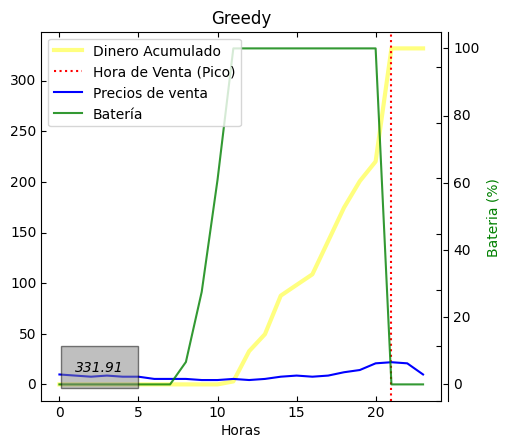

                  Greedy
Ev. Medias          1.00
Ev. Mejor           1.00
Ev. Desviación      0.00
Mejor €           331.91
Media €           331.91
Desviación €        0.00
Ev. Mejor Dinero    1.00


In [21]:
algorithm_name = greedy_name

Algorithms_names.append(algorithm_name)

greedy_data = evaluar_algoritmo(greedy_name)

Data.append(greedy_data)

## Algoritmos de Búsquedas Locales
Parten de una solución inicial e iterativamente tratan de reemplazarla por otra solución de su vecindario con mejor calidad

### Búsqueda aleatoria

El Algoritmo de Búsqueda Aleatoria (BA) consistirá en generar aleatoriamente una solución en cada iteración debiéndose ejecutar 100 iteraciones con cada semilla devolviendo la mejor de las iteraciones.

Se elige aleatoriamente una muestra de soluciones del espacio de búsqueda y se devuelve la mejor.

Se diría que el entorno de una solución es todo el espacio de búsqueda:
E(S) = "todo el espacio de búsqueda".

Si el problema tiene m soluciones y el óptimo es único, la probabilidad de que al generar aleatoriamente una solución se obtenga la óptima es 1/m.

In [22]:
def busqueda_aleatoria(iteraciones = 100):
    totales_dinero = []
    contador_evaluaciones = [0]

    solucion_actual = solucion_inicial()

    contador_evaluaciones[0] += 1
    valor_solucion_actual = funcion_evaluacion(solucion_actual)

    solucion_mejor = solucion_actual
    valor_mejor_solucion = valor_solucion_actual

    for iteracion in range(iteraciones):
        solucion_actual = solucion_inicial()

        contador_evaluaciones[0] += 1
        valor_solucion_actual = funcion_evaluacion(solucion_actual)

        totales_dinero.append(valor_solucion_actual)

        if valor_solucion_actual > valor_mejor_solucion:
            solucion_mejor = solucion_actual
            valor_mejor_solucion = valor_solucion_actual

    return solucion_mejor, contador_evaluaciones, totales_dinero

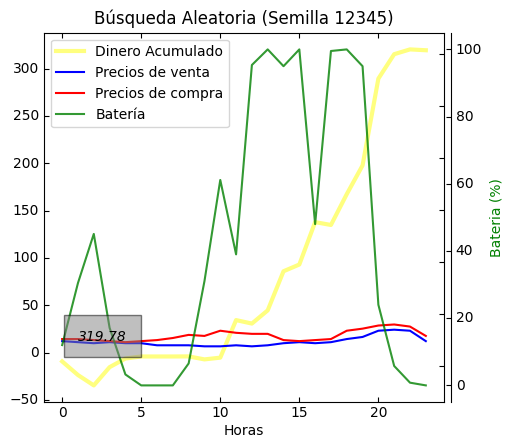

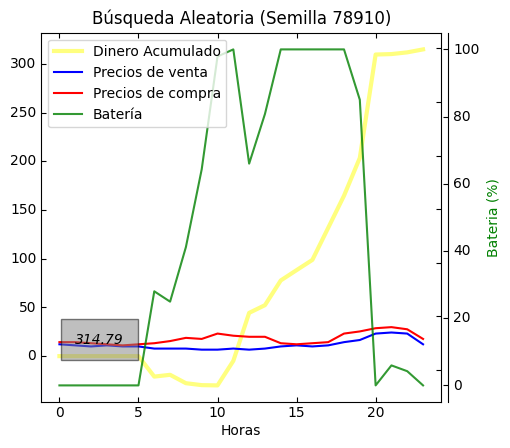

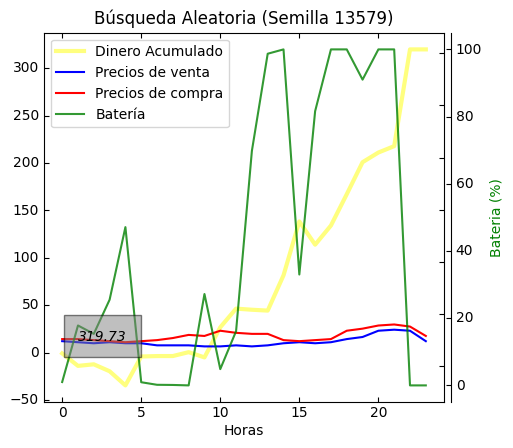

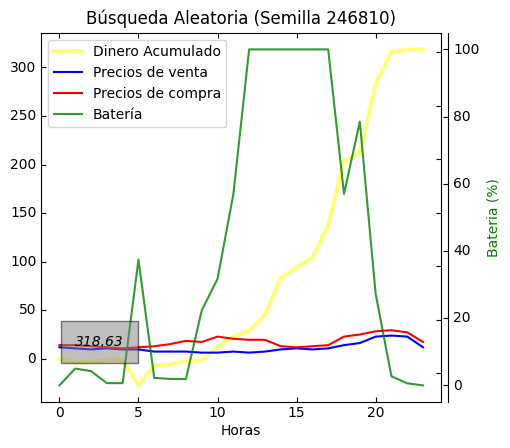

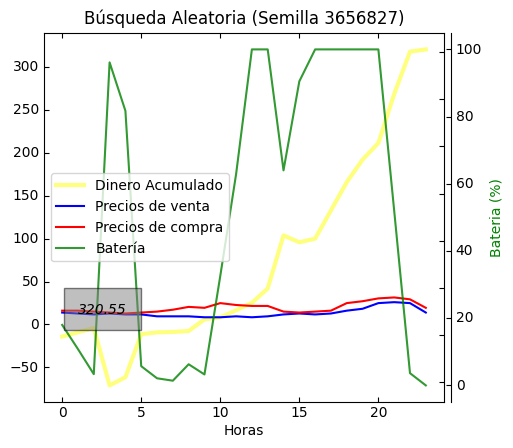

                 Búsqueda Aleatoria
Ev. Medias                     5001
Ev. Mejor                      5001
Ev. Desviación              1149.51
Mejor €                      320.55
Media €                      319.73
Desviación €                   2.29
Ev. Mejor Dinero            5: 3634


In [23]:
iteraciones = 5000

algorithm_name = busqueda_aleatoria_name

Algorithms_names.append(algorithm_name)

busqueda_aleatoria_data = evaluar_algoritmo(algorithm_name, iteraciones)

Data.append(busqueda_aleatoria_data)

### El primer mejor y el mejor vecino

Se implementará siguiendo el esquema de el primer mejor y el mejor vecino, según el Tema 1 de teoría.

Se partirá de una solución inicial aleatoria. Los algoritmos de búsqueda local tienen su propia condición de parada, pero adicionalmente, en prevención de tiempos excesivos en algún caso, se añadirá una condición de parada alternativa (OR) basada en el número de evaluaciones que esté realizando la búsqueda, es decir, el número de veces se llame al cálculo de la función de coste. Este valor para la Búsqueda Local será de 3000 llamadas a la función de coste.

Para el número de vecinos del primer mejor se pasará a la siguiente solución cuando se encuentre un vecino mejor mediante una operación de movimiento o se haya alcanzado el número máximo de intentos sin mejora.

Haz un estudio de granularidad del operador de movimiento (al menos tres valores) respecto a la calidad de la solución encontrada. Para ello deberá mostrar varios gráficos de mejor solución (total euros generados) en cada iteración para cada velocidad.

Sobre busqueda local primero mejor:

Los valores de los parámetros max_evaluaciones y max_intentos_sin_mejora deben ser razonables para el problema específico porque estos parámetros afectan la cantidad de tiempo y recursos necesarios para ejecutar el algoritmo de búsqueda local.

El parámetro max_evaluaciones establece el número máximo de evaluaciones de la función de evaluación permitidas. Si el valor es demasiado bajo, el algoritmo puede no ser capaz de encontrar una solución óptima o incluso una solución aceptable. Si el valor es demasiado alto, el algoritmo puede tardar demasiado tiempo en ejecutarse, lo que lo hace ineficiente.

El parámetro max_intentos_sin_mejora establece el número máximo de iteraciones permitidas sin que se produzca una mejora en la solución. Si el valor es demasiado bajo, el algoritmo puede detenerse prematuramente antes de encontrar una solución óptima o aceptable. Si el valor es demasiado alto, el algoritmo puede continuar ejecutándose durante mucho tiempo, lo que también lo hace ineficiente.

Por lo tanto, es importante ajustar estos parámetros según las características específicas del problema para encontrar un equilibrio entre la calidad de la solución y el tiempo y recursos necesarios para encontrarla.

Búsqueda Local del Mejor (…el mejor vecino del entorno)

A partir de la solución actual genera todo el entorno completo de ella y selecciona la mejor solución vecina.

A continuación, comprueba si esa mejor vecina de la solución actual es mejor que la propia solución actual, y:
- En caso afirmativo la sustituye y vuelve a iterar
- En caso de que no, el algoritmo finaliza.

In [24]:
def generar_mejor_vecino_mejor(solucion_actual):
    contador_evaluaciones = 0

    vecinos = generador_vecino(solucion_actual)

    valor_mejor_vecino = float("-inf")
    mejor_vecino = None

    for vecino in vecinos:
        valor_vecino = funcion_evaluacion(vecino)
        contador_evaluaciones += 1

        # Si el mejor vecino mejora la solución actual, se actualiza la solución actual
        if (not mejor_vecino) or (valor_vecino > valor_mejor_vecino):
            mejor_vecino = vecino
            valor_mejor_vecino = valor_vecino

    return mejor_vecino, valor_mejor_vecino, contador_evaluaciones

def condicion_de_parada_mejor(valor_mejor_vecino, valor_solucion_actual):
    if valor_mejor_vecino <= valor_solucion_actual:
        return True
    else:
        return False

def busqueda_local_mejor(max_evaluaciones=3000):

    # Parametros de control
    totales_dinero = []
    contador_evaluaciones = [0]

    # Generar solución inicial
    solucion_actual = solucion_inicial()

    valor_solucion_actual = funcion_evaluacion(solucion_actual)
    contador_evaluaciones[0] += 1
    totales_dinero.append(valor_solucion_actual)

    valor_mejor_vecino = float("-inf")

    while (not condicion_de_parada_mejor(valor_mejor_vecino, valor_solucion_actual)) or (contador_evaluaciones[0] < max_evaluaciones): # and intentos_sin_mejora < max_intentos_sin_mejora: -> esto es para mej no de salida

        # Obtiene el mejor vecino del entorno
        mejor_vecino, valor_mejor_vecino, aux_contador = generar_mejor_vecino_mejor(solucion_actual)
        contador_evaluaciones[0] += aux_contador

        if valor_mejor_vecino > valor_solucion_actual:
            valor_solucion_actual = valor_mejor_vecino
            solucion_actual = mejor_vecino

        totales_dinero.append(valor_solucion_actual)

    return solucion_actual, contador_evaluaciones, totales_dinero

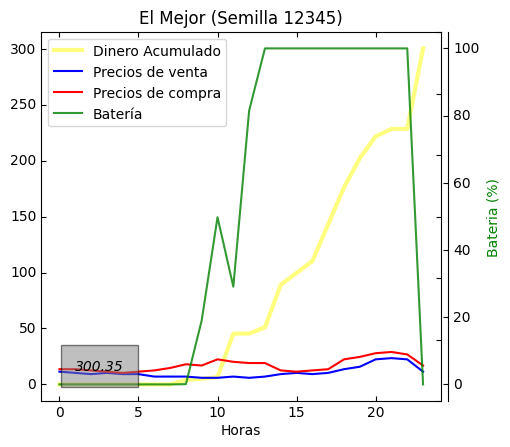

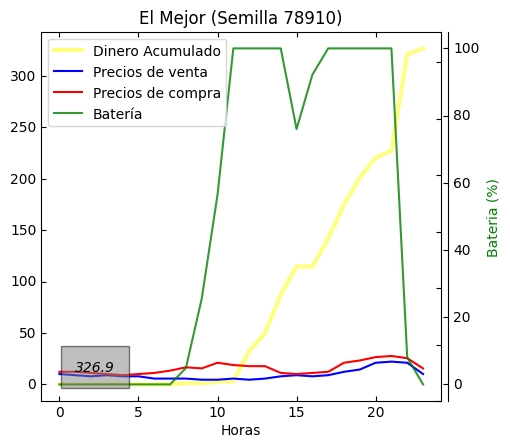

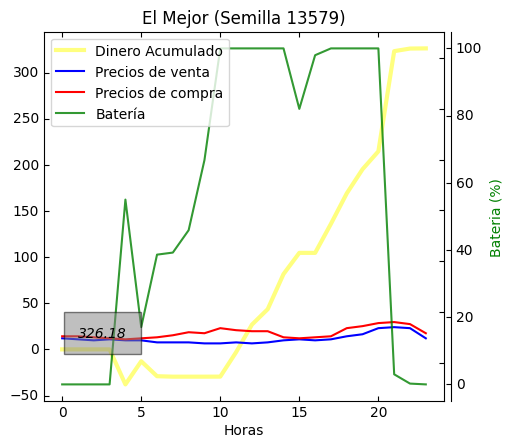

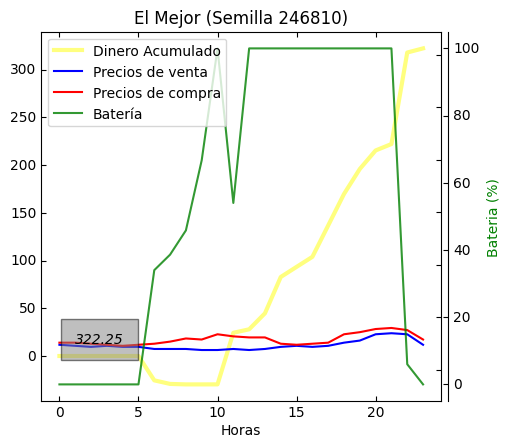

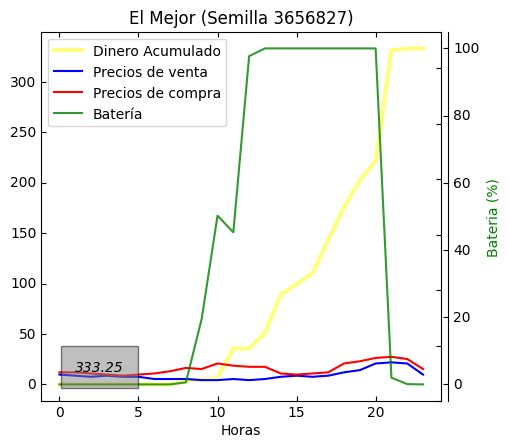

                 El Mejor
Ev. Medias           5018
Ev. Mejor            5003
Ev. Desviación      15.82
Mejor €            333.25
Media €            326.18
Desviación €        12.62
Ev. Mejor Dinero    5: 76


In [25]:
max_evaluaciones=5000

parametros = [max_evaluaciones]

algorithm_name = mejor_name

Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)
Data.append(mejor_data)

In [26]:
def generar_mejor_vecino_primero_mejor(solucion_actual):
    contador_evaluaciones = 0

    vecinos = generador_vecino(solucion_actual)

    valor_mejor_vecino = float("-inf")
    mejor_vecino = None

    n_vecino = 0

    for vecino in vecinos:
        valor_vecino = funcion_evaluacion(vecino)
        contador_evaluaciones += 1

        # solo la primera iteracion se establece el mejor vecino
        if not mejor_vecino:
            mejor_vecino = vecino
            valor_mejor_vecino = funcion_evaluacion(mejor_vecino)
            contador_evaluaciones += 1

        # Actualizar y condicion de parada, break y devolver funcion
        if valor_vecino > valor_mejor_vecino:
            mejor_vecino = vecino
            valor_mejor_vecino = valor_vecino
            return mejor_vecino, valor_mejor_vecino, contador_evaluaciones

    return mejor_vecino, valor_mejor_vecino, contador_evaluaciones

def condicion_de_parada_primero_mejor(valor_mejor_vecino, valor_solucion_actual):
    if valor_mejor_vecino <= valor_solucion_actual:
        return True
    else:
        return False

def busqueda_local_primero_mejor(max_evaluaciones=3000, max_intentos_sin_mejora=50):

    # Parametros de control
    totales_dinero = []
    contador_evaluaciones = [0]
    intentos_sin_mejora = 0

    # Generar solución inicial
    solucion_actual = solucion_inicial()

    valor_solucion_actual = funcion_evaluacion(solucion_actual)
    contador_evaluaciones[0] += 1
    totales_dinero.append(valor_solucion_actual)

    valor_mejor_vecino = float("-inf")

    solucion_mejor = solucion_actual
    valor_solucion_mejor = float("-inf")

    while (not condicion_de_parada_primero_mejor(valor_mejor_vecino, valor_solucion_actual)) or (contador_evaluaciones[0] < max_evaluaciones):

        # Obtiene el mejor vecino del entorno
        mejor_vecino, valor_mejor_vecino, aux_contador = generar_mejor_vecino_primero_mejor(solucion_actual)
        contador_evaluaciones[0] += aux_contador

        if (valor_mejor_vecino > valor_solucion_actual) or intentos_sin_mejora >= max_intentos_sin_mejora:
            valor_solucion_actual = valor_mejor_vecino
            solucion_actual = mejor_vecino
            intentos_sin_mejora = 0
        else:
            intentos_sin_mejora += 1

        if valor_solucion_actual > valor_solucion_mejor:
            solucion_mejor = solucion_actual
            valor_solucion_mejor = valor_solucion_actual

        totales_dinero.append(valor_solucion_mejor)
        # DUDA: CREAR UNA VARIABLE MEJOR SOLUCION Y AL FINAL DEVOLVER MEJOR SOLUCION O SE DEVUELVE LA MEJOR A LA QUE SE HAYA LLEGADO (?)

    return solucion_mejor, contador_evaluaciones, totales_dinero

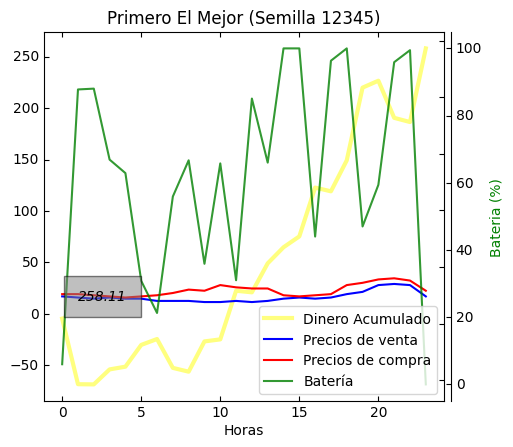

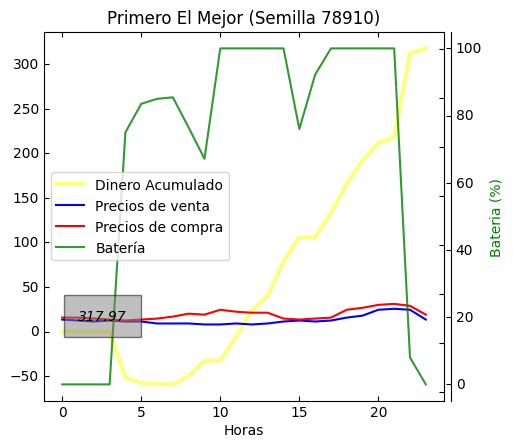

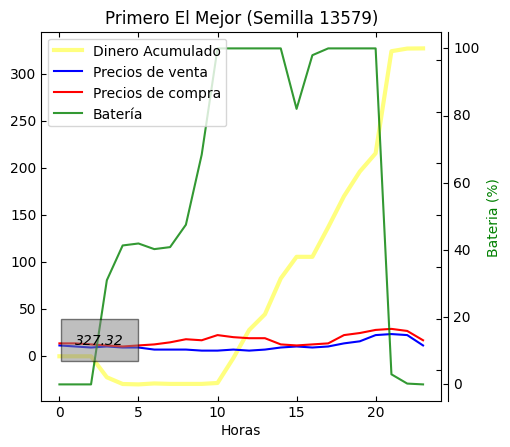

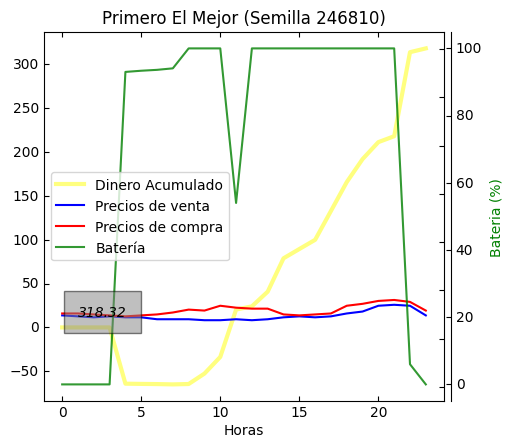

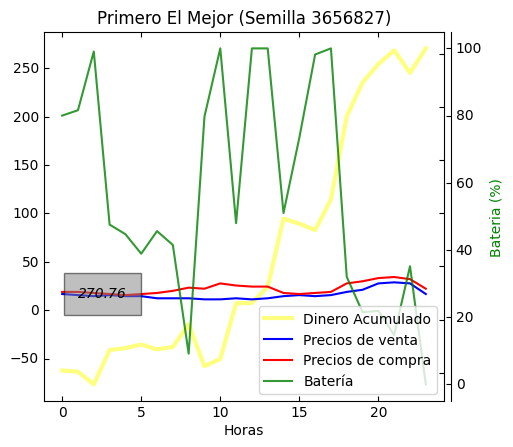

                 Primero El Mejor
Ev. Medias                   5013
Ev. Mejor                    5001
Ev. Desviación              46.29
Mejor €                    327.32
Media €                    317.97
Desviación €                31.64
Ev. Mejor Dinero           3: 103


In [27]:
max_evaluaciones=5000
max_intentos_sin_mejora=3000

parametros = [max_evaluaciones, max_intentos_sin_mejora]

algorithm_name = primero_mejor_name

Algorithms_names.append(algorithm_name)

primero_mejor_data = evaluar_algoritmo(algorithm_name, parametros)
Data.append(primero_mejor_data)

### Búsqueda Local VND
Se implementará 5 niveles de velocidad variable según lo indicado en la teoría.

Modificar la estructura de entornos

Caso particular de VNS: VND
VND: Búsqueda Descendente de Entorno Variable

VNS
1. Un mínimo local con una estructura de entornos no lo es necesariamente con otra.
2. Un mínimo global es mínimo local con todas las posibles estructuras
de entornos.
3. Para muchos problemas, los mínimos locales con la misma o distinta estructura de entorno están relativamente cerca.

Los hechos 1 a 3 sugieren el empleo de varias estructuras de entornos en las búsquedas locales para abordar un problema de optimización: Origen de VNS y sus derivados.

El cambio de estructura de entornos se puede realizar de forma determinística (técnica VND), La búsqueda VND modifica la estructura de entornos como mecanismo para evitar caer en óptimos locales.

VND se basa en el algoritmo de búsqueda local del mejor, permitiendo que el operador de vecino cambie de entorno (ampliándolo) cuando el mejor vecino generado no mejora a la solución actual.

Los pasos de la VND se muestran a continuación:
1. Inicialización
• Seleccionar el conjunto de estructura de entornos Ek, k = 1, …, kmax, que se usarán en el descenso.
• Generar una solución inicial s.

2. Iteraciones
• Repetir, hasta que k=kmax, la siguiente secuencia:
(a) Exploración del entorno: Encontrar la mejor solución s' del k-ésimo entorno de s (s' pertenece a Ek(s));
(b) Moverse o no: Si la solución obtenida s' es mejor que s, hacer s <- s' y k <- 1; en otro caso, hacer k <- k + 1

In [28]:
def busqueda_local_vnd():

    # parametros de control
    totales_dinero = []
    contador_evaluaciones = [0]

    mejor_solucion = solucion_inicial()

    nivel_velocidad = 1
    while nivel_velocidad <= 5:
        solucion_actual = mejor_solucion
        valor_solucion_actual = funcion_evaluacion(solucion_actual)
        valor_mejor_solucion = valor_solucion_actual
        contador_evaluaciones[0] += 1

        vecinos = generador_vecino(solucion_actual, granularidad=nivel_velocidad)

        for vecino in vecinos:
            valor_solucion_vecino = funcion_evaluacion(vecino)
            contador_evaluaciones[0] += 1

            if valor_solucion_vecino < valor_solucion_actual:
                solucion_actual = vecino
                valor_solucion_actual = valor_solucion_vecino

        if valor_solucion_actual < valor_mejor_solucion:
            mejor_solucion = solucion_actual
            valor_mejor_solucion = valor_solucion_actual
            totales_dinero.append(valor_mejor_solucion)
            nivel_velocidad = 1
        else:
            nivel_velocidad += 1

    return mejor_solucion, contador_evaluaciones, totales_dinero

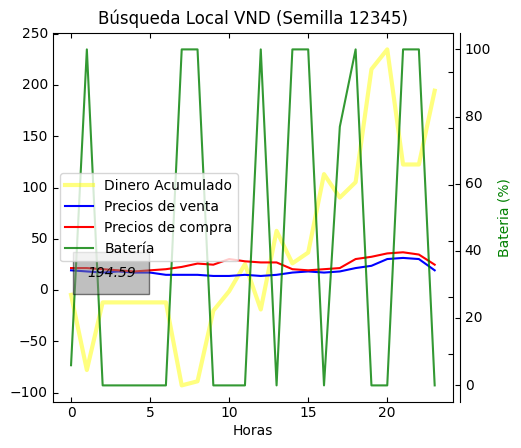

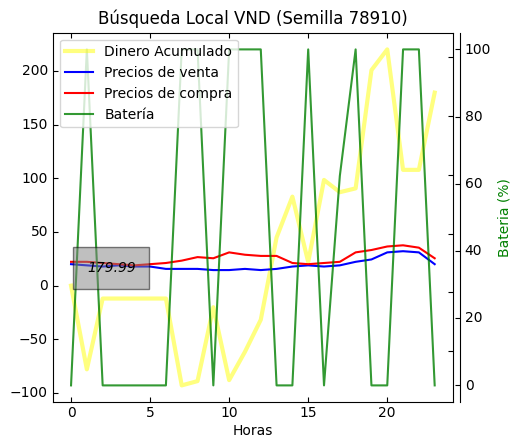

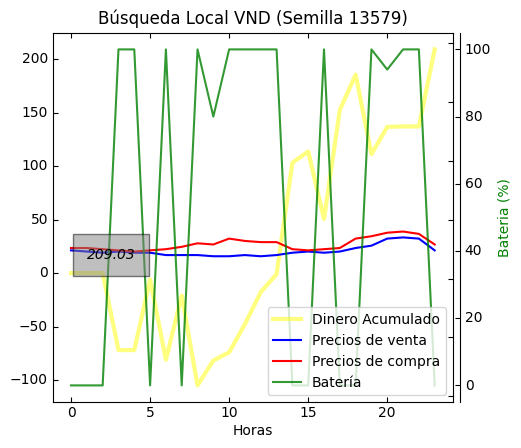

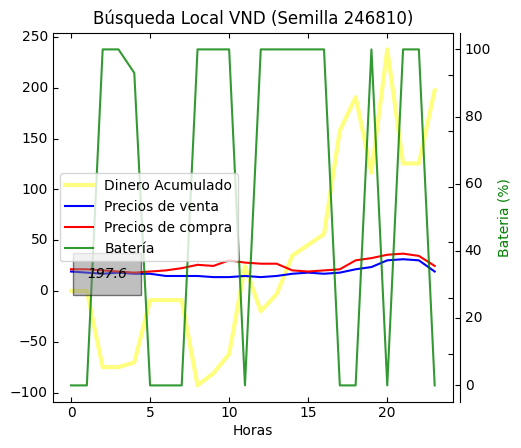

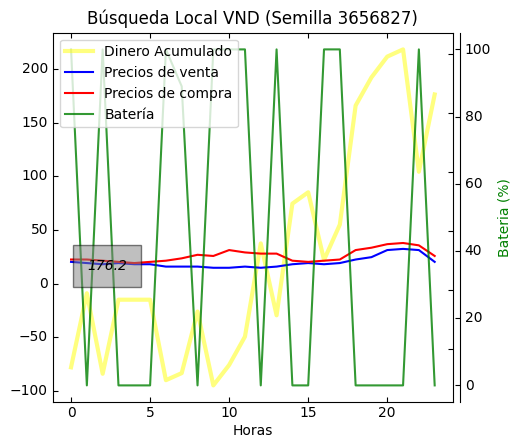

                 Búsqueda Local VND
Ev. Medias                    30534
Ev. Mejor                     24559
Ev. Desviación                  0.0
Mejor €                      282.35
Media €                      266.78
Desviación €                   9.17
Ev. Mejor Dinero               3: 0


In [29]:
algorithm_name = busqueda_local_vnd_name

Algorithms_names.append(algorithm_name)

primero_mejor_data = evaluar_algoritmo(algorithm_name)
Data.append(primero_mejor_data)

In [30]:
# Función para generar un vecino aleatorio
def generar_vecino_vnd(solucion, nivel):
    if nivel == 1:
        return generar_vecino_swap(solucion)
    elif nivel == 2:
        return generar_vecino_insert(solucion)
    elif nivel == 3:
        return generar_vecino_reverse(solucion)
    elif nivel == 4:
        return generar_vecino_shuffle(solucion)
    else:
        return generar_vecino_double_bridge(solucion)

# Funciones para generar vecinos en diferentes estructuras de entornos
def generar_vecino_swap(solucion):
    n = len(solucion)
    i = random.randint(0, n - 1)
    j = random.randint(0, n - 1)
    while i == j:
        j = random.randint(0, n - 1)
    vecino = solucion[:]
    vecino[i], vecino[j] = vecino[j], vecino[i]
    return vecino

def generar_vecino_insert(solucion):
    n = len(solucion)
    i = random.randint(0, n - 1)
    j = random.randint(0, n - 1)
    while i == j:
        j = random.randint(0, n - 1)
    vecino = solucion[:]
    elem = vecino.pop(i)
    vecino.insert(j, elem)
    return vecino

def generar_vecino_reverse(solucion):
    n = len(solucion)
    i = random.randint(0, n - 1)
    j = random.randint(0, n - 1)
    while i == j:
        j = random.randint(0, n - 1)
    vecino = solucion[:]
    if i > j:
        i, j = j, i
    vecino[i:j+1] = reversed(vecino[i:j+1])
    return vecino

def generar_vecino_shuffle(solucion):
    n = len(solucion)
    i = random.randint(0, n - 2)
    j = random.randint(i+1, n - 1)
    vecino = solucion[:]
    vecino[i:j+1] = random.sample(vecino[i:j+1], j-i+1)
    return vecino

def generar_vecino_double_bridge(solucion):
    n = len(solucion)
    p = n // 4
    i = random.randint(0, p-1)
    j = random.randint(p, 2*p-1)
    k = random.randint(2*p, 3*p-1)
    l = random.randint(3*p, n-1)
    vecino = solucion[:i] + solucion[k:l] + solucion[j:k] + solucion[i:j] + solucion[l:]
    return vecino

# Función para calcular el costo de una solución
def calcular_costo(solucion):
    # Implementar función que calcule el costo de la solución
    pass

# Búsqueda Local VND con 5 niveles de velocidad variable
def busqueda_local_vnd(kmax):
    solucion_actual = solucion_inicial()
    k = 1

    contador_evaluaciones = [0]
    totales_dineros = []

    while k <= kmax:
        vecino = generar_vecino_vnd(solucion_actual, k)
        costo_vecino = funcion_evaluacion(vecino)
        costo_actual = funcion_evaluacion(solucion_actual)
        if costo_vecino < costo_actual:
            solucion_actual = vecino
            k = 1
        else:
            k += 1

        contador_evaluaciones[0] += 1
        totales_dineros.append(costo_actual)

    return solucion_actual, contador_evaluaciones, totales_dineros

In [31]:
'''tmax = 40

parametros = [tmax]

algorithm_name = busqueda_local_vnd_name

busqueda_local_vnd_data = evaluar_algoritmo(algorithm_name, parametros)

Algorithms_names.append(algorithm_name)

busqueda_local_vnd_data = [0,0,0,0,0,0]
Data.append(busqueda_local_vnd_data)'''

'tmax = 40\n\nparametros = [tmax]\n\nalgorithm_name = busqueda_local_vnd_name\n\nbusqueda_local_vnd_data = evaluar_algoritmo(algorithm_name, parametros)\n\nAlgorithms_names.append(algorithm_name)\n\nbusqueda_local_vnd_data = [0,0,0,0,0,0]\nData.append(busqueda_local_vnd_data)'

### Simulated Annealing
Permitir movimientos de empeoramiento

El algoritmo de Enfriamiento Simulado es un método de búsqueda por entornos, caracterizado por un criterio de aceptación de soluciones vecinas que se adapta a lo largo de su ejecución.

Hace uso de una variable llamada Temperatura, T, cuyo valor determina en qué medida pueden ser aceptadas soluciones vecinas peores que la actual.

La variable Temperatura se inicializa a un valor alto, denominado Temperatura inicial, T0, y se va reduciendo cada iteración mediante un mecanismo de enfriamiento de la temperatura, a(·), hasta alcanzar una Temperatura final, Tf.

En cada iteración se genera un número concreto de vecinos, L(T), que puede ser fijo para toda la ejecución o depender de la iteración concreta.

Cada vez que se genera un vecino, se aplica el criterio de aceptación para ver si sustituye a la solución actual:
- Si es mejor que la actual, se acepta automáticamente, tal como se haría en la BL.
- En cambio, si es peor, aún existe la probabilidad de que el vecino sustituya a la solución actual. Esto permite al algoritmo salir de óptimos locales, en los que la BL quedaría atrapada.

Esta probabilidad depende de la diferencia de costes entre la solución actual y la vecina, δ, y de la temperatura T:
Paceptación= exp(-δ/T)

- Interpretación 1: A mayor temperatura, mayor probabilidad de aceptación de soluciones peores. Así, el algoritmo acepta soluciones mucho peores que la actual al principio de la ejecución (exploración) pero no al final (explotación)
- Interpretación 2: A menor diferencia de costes, mayor probabilidad de aceptación de soluciones peores

Una vez finalizada la iteración, es decir, tras generar L(T) soluciones vecinas, se enfría la temperatura y se pasa a la siguiente iteración

In [117]:
# Función para calcular la temperatura inicial
def temperatura_inicial(valor_solucion_inicial, phi, mu):
    return (mu / -math.log(phi)) * valor_solucion_inicial

def experimento(n_max_iteraciones):

    mu_values = np.arange(0.1,0.3,0.1)
    phi_values = np.arange(0.1,0.3,0.1)
    mejor_mu = None
    mejor_phi = None

    # Ejecutar algoritmo Greedy
    solucion_actual = solucion_inicial()

    solucion_greedy = solucion_actual
    valor_greedy = greedy(False)

    mejor_proporcion = float("inf")

    # Ejecutar recocido simulado con diferentes valores de mu y phi
    for mu_value in mu_values:
        for phi_value in phi_values:

            num_soluciones_no_aceptadas = 0

            for semilla in semillas:
                # establecer semilla
                random.seed(semilla)

                for _ in range(50):
                    # coger solucion actual de simulated annealing
                    solucion_actual,_,_ = simulated_annealing(n_max_iteraciones, mu, phi, solucion_inicial=solucion_greedy)
                    valor_solucion_actual = funcion_evaluacion(solucion_actual)

                    # si mejora -> no se acepta la sol
                    if valor_solucion_actual < valor_greedy:
                        num_soluciones_no_aceptadas += 1

            proporcion = ((num_soluciones_no_aceptadas/((len(semillas))*n_max_iteraciones)) / 0.2)

            '''print("===============================================================0")
            print("semilla:               " + str(semilla))
            print("mu:                    " + str(mu_value))
            print("phi:                   " + str(phi_value))
            print("proporcion aceptada:   " + str(proporcion))'''


            # Verificar si el número de soluciones no aceptadas cumple con el criterio
            if proporcion < mejor_proporcion:
                mejor_mu = mu_value
                mejor_phi = phi_value
                mejor_proporcion = proporcion
                print("============= Nuevos mejores ====================0")
                print("mu:                    " + str(mejor_mu))
                print("phi:                   " + str(mejor_phi))
                print("proporcion aceptada:   " + str(proporcion))

    return mejor_mu, mejor_phi

experimento(50)


============= Nuevos mejores ====================0
mu:                    0.1
phi:                   0.1
proporcion aceptada:   5.0


(0.1, 0.1)

In [104]:
# Función para generar un vecino aleatorio
def seleccionar_vecino_sa(solucion_actual):
    # genera vecinos
    vecinos = generador_vecino(solucion_actual)
    # genera numero aleatorio para coger ese vecino aleatorio
    num_random = random.randint(0, len(vecinos)-1)
    # coge ese vecino aleatorio
    vecino = vecinos[num_random]
    return vecino

# Función para calcular la temperatura inicial
def temperatura_inicial(valor_solucion_inicial, phi, mu):
    return (mu / -math.log(phi)) * valor_solucion_inicial

# Función de enfriamiento
def enfriamiento_cauchy(temperatura, k):
    return temperatura / (1 + k)

def condicion_parada(n_iteracion, n_max_iteraciones):
    #Comprueba si se ha alcanzado el número máximo de iteraciones
    return n_iteracion >= n_max_iteraciones

def condicion_enfriamiento(temperatura, num_vecinos_generados):
    k = num_vecinos_generados + 1  # se suma 1 porque se está generando el vecino actual
    # nueva_temperatura = temperatura / (1 + k)
    nueva_temperatura = enfriamiento_cauchy(temperatura, k)
    return nueva_temperatura # max(nueva_temperatura, 0.0141)

def seleccionar_solucion(solucion, pos, granularidad = 10):
    solucion_vecina = solucion.copy()

    dado = random.randint(0, 1)  # 0 = incrementar, 1 = decrementar

    if dado == 0:  # Incrementa
        solucion_vecina[pos] += granularidad
        if solucion_vecina[pos] > 100:
            solucion_vecina[pos] = 100
    else:  # Decrementa
        solucion_vecina[pos] -= granularidad
        if solucion_vecina[pos] < -100:
            solucion_vecina[pos] = -100

    return solucion_vecina

# Implementación del algoritmo Simulated Annealing
def simulated_annealing(n_max_iteraciones, phi, mu, num_vecinos = 40, solucion_inicial = solucion_inicial()):

    # parametros de control
    contador_evaluaciones = [0]
    totales_dinero = []

    # Generar solución inicial
    solucion_actual = solucion_inicial
    valor_solucion_actual = funcion_evaluacion(solucion_actual)

    # Parámetros de control
    mejor_solucion = solucion_actual.copy()
    valor_mejor_solucion = valor_solucion_actual

    temperatura_0 = temperatura_inicial(valor_solucion_actual, phi, mu)
    temperatura = temperatura_0

    num_vecinos_generados = 0

    iteracion = 0

    while not condicion_parada(iteracion, n_max_iteraciones):

        for _ in range(0,num_vecinos):
            # Generar un vecino aleatorio
            vecino = seleccionar_vecino_sa(solucion_actual)
            # Actualizar el número de vecinos generados
            num_vecinos_generados += 1

            solucion_candidata = vecino
            valor_solucion_candidata = funcion_evaluacion(solucion_candidata)
            contador_evaluaciones[0] += 1

            '''# Actualizar el número de vecinos generados
            num_vecinos_generados += 1'''

            # Calcular la probabilidad de aceptar el vecino
            delta = valor_mejor_solucion - valor_solucion_actual
            # delta = valor_mejor_solucion - valor_solucion_candidata

            try:
                probabilidad_aceptacion = math.exp(-delta / temperatura)
            except ZeroDivisionError:
                probabilidad_aceptacion = float('inf')
            except OverflowError:
                probabilidad_aceptacion = float('inf')

            # Si el vecino es mejor, se acepta
            if random.uniform(0, 1) < probabilidad_aceptacion or delta < 0:
                solucion_actual = solucion_candidata
                valor_solucion_actual = valor_solucion_candidata

                # Si se mejora la mejor solución encontrada, se actualiza
                if valor_solucion_actual > valor_mejor_solucion:
                    mejor_solucion = solucion_actual
                    valor_mejor_solucion = valor_solucion_actual

            # guardar totales dinero
            totales_dinero.append(valor_mejor_solucion)

        # Enfriar la temperatura
        temperatura = condicion_enfriamiento(temperatura, num_vecinos_generados)

        # Incrementar la iteración
        iteracion += 1

    return mejor_solucion, contador_evaluaciones, totales_dinero

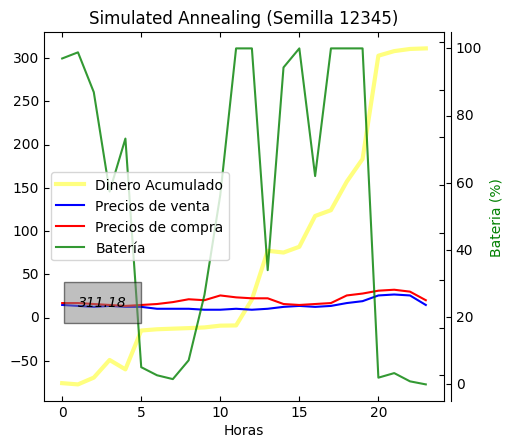

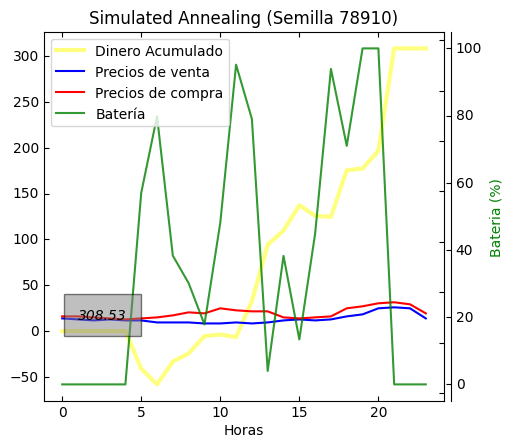

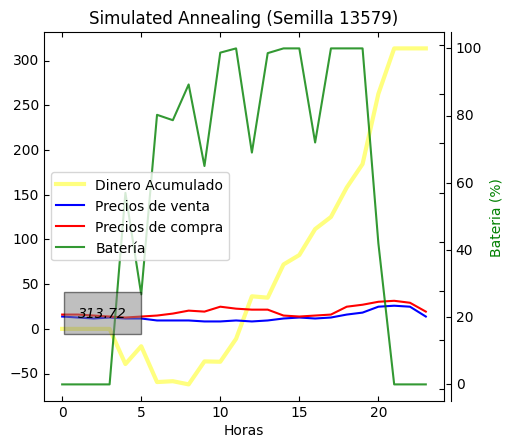

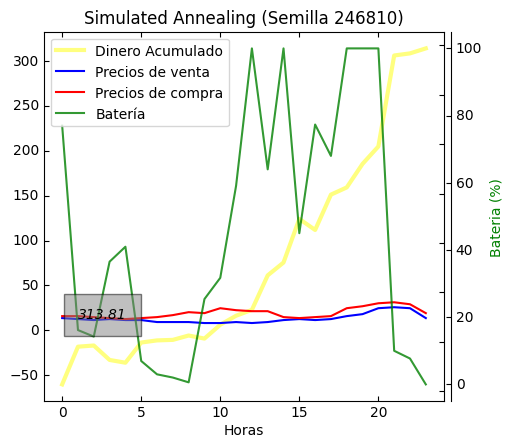

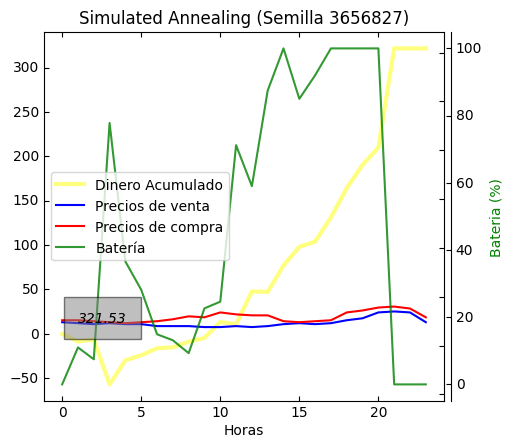

                 Simulated Annealing
Ev. Medias                    200000
Ev. Mejor                     200000
Ev. Desviación              51949.33
Mejor €                       321.53
Media €                       313.72
Desviación €                    4.86
Ev. Mejor Dinero           5: 172732


In [107]:
n_max_iteraciones = 5000
phi = 0.2
mu = 0.2

parametros = [n_max_iteraciones, phi, mu]

algorithm_name = enfriamiento_simulado_name
Algorithms_names.append(algorithm_name)

enfriamiento_simulado_data = evaluar_algoritmo(algorithm_name, parametros)

Data.append(enfriamiento_simulado_data)

### Búsqueda Tabú
Permitir movimientos de empeoramiento
Modificar la estructura de entornos

In [34]:
def busqueda_tabu(tmax):
    # Parámetros de la búsqueda tabú
    tabu_list = [] # tabu_list

    solucion_mejor = None
    valor_mejor_solucion = float('-inf')

    evaluaciones = 0
    contador_evaluaciones = [0]
    totales_dinero = []

    # Generar la solución inicial
    solucion_actual = solucion_inicial()
    valor_solucion_actual = funcion_evaluacion(solucion_actual)

    # Mientras no se cumpla el criterio de parada
    tiempo_inicio = time.time()
    while (time.time() - tiempo_inicio) < tmax:
        # Incrementar la iteración

        # Generar la vecindad de la solución actual
        vecindad = []

        vecinos = generador_vecino(solucion_actual)

        for vecino in vecinos:
            if vecino not in tabu_list:
                vecindad.append(vecino)

        # Evaluar la vecindad y actualizar la mejor solución
        solucion_mejor_vecina = None
        valor_mejor_vecino = float('-inf')

        for solucion_vecina in vecindad:
            valor_vecino = funcion_evaluacion(solucion_vecina)

            if valor_vecino > valor_mejor_vecino:
                solucion_mejor_vecina = solucion_vecina
                valor_mejor_vecino = valor_vecino

        # Actualizar la solución actual y la lista tabú
        solucion_actual = solucion_mejor_vecina
        valor_actual = valor_mejor_vecino

        tabu_list.append(solucion_actual)

        # Actualizar la mejor solución
        if valor_mejor_vecino > valor_mejor_solucion:
            solucion_mejor = solucion_mejor_vecina
            valor_mejor_solucion = valor_mejor_vecino

        # Eliminar elementos antiguos de la lista tabú
        if len(tabu_list) > 10:
            tabu_list.pop(0)

        contador_evaluaciones[0] += 1
        totales_dinero.append(valor_actual)

    # Devolver la mejor solución encontrada
    return solucion_mejor, contador_evaluaciones, totales_dinero

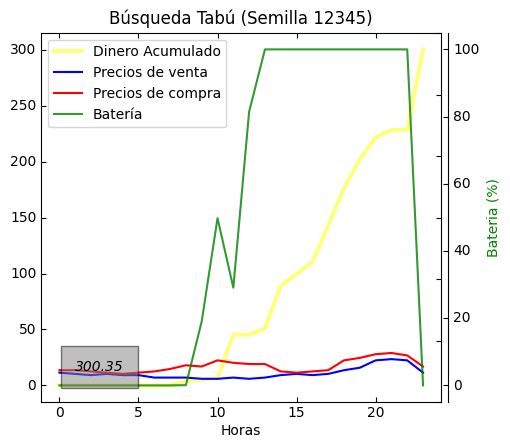

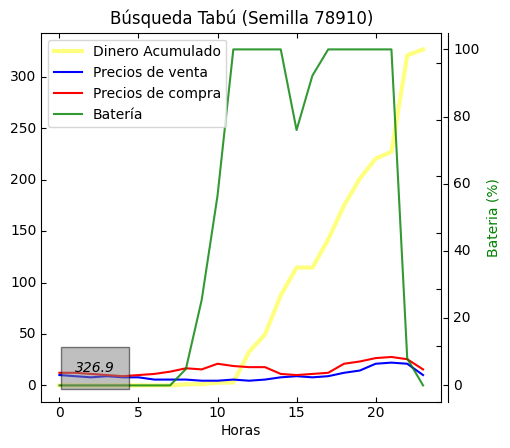

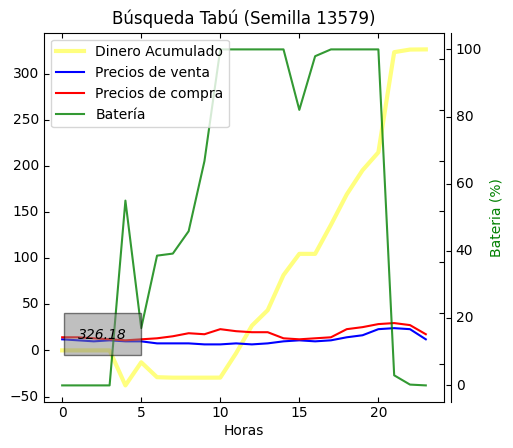

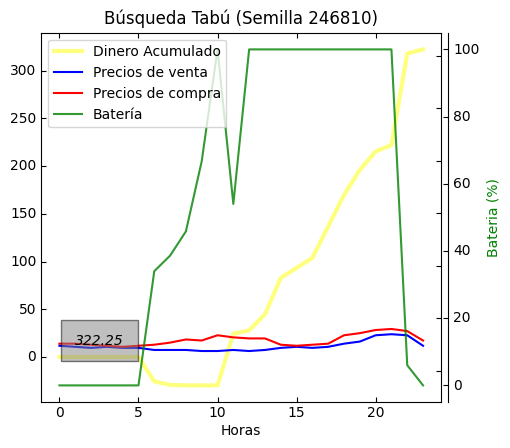

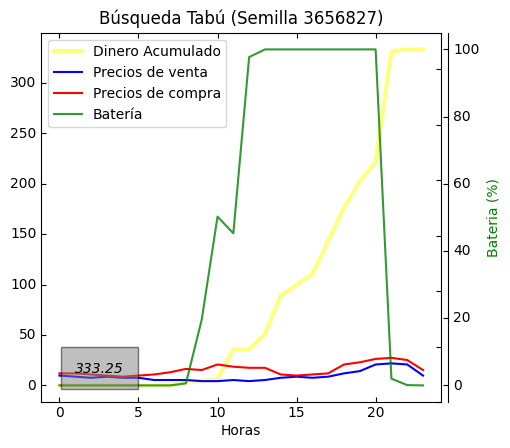

                 Búsqueda Tabú
Ev. Medias               30247
Ev. Mejor                29852
Ev. Desviación           15.82
Mejor €                 333.25
Media €                 326.18
Desviación €             12.62
Ev. Mejor Dinero         5: 75


In [35]:
tmax = 40

parametros = [tmax]

algorithm_name = busqueda_tabu_name
Algorithms_names.append(algorithm_name)

busqueda_tabu_data = evaluar_algoritmo(algorithm_name, parametros)

Data.append(busqueda_tabu_data)

In [ ]:
Header = ["Ev. Medias", "Ev. Mejor", "Ev. Desviación", "Mejor €", "Media €", "Desviación €"]

import numpy as np

Data_copy = np.array(Data)

# print(pd.DataFrame(Data.transpose(), Header, column))

# ev_media, ev_mejor, ev_desviacion, euro_mejor, euro_media, euro_desviacion = v

format_row = "{:>18}" * (len(Header) + 1)
print(format_row.format("", *Algorithms_names))
for dat, row in zip(Header, Data_copy.transpose()):
    print(format_row.format(dat, *row))

In [ ]:
# Función para generar un vecino aleatorio
def generar_vecino_sa(solucion_actual):
    # genera vecinos
    vecinos = generador_vecino(solucion_actual)
    # genera numero aleatorio para coger ese vecino aleatorio
    num_random = random.randint(0, len(vecinos)-1)
    # coge ese vecino aleatorio
    vecino = vecinos[num_random]
    return vecino

# Implementación del algoritmo Simulated Annealing
def simulated_annealing(n_max_iteraciones, phi, mu, num_vecinos = 40, solucion_inicial = solucion_inicial()):

    # parametros de control
    contador_evaluaciones = [0]
    totales_dinero = []

    # Generar solución inicial
    solucion_actual = solucion_inicial
    valor_solucion_actual = funcion_evaluacion(solucion_actual)

    # Parámetros de control
    mejor_solucion = solucion_actual.copy()
    valor_mejor_solucion = valor_solucion_actual

    temperatura_0 = temperatura_inicial(valor_solucion_actual, phi, mu)
    temperatura = temperatura_0

    num_vecinos_generados = 0

    iteracion = 0

    while not condicion_parada(iteracion, n_max_iteraciones):

        # Generar un vecino aleatorio
        vecino = generar_vecino_sa(solucion_actual)
        valor_vecino = funcion_evaluacion(vecino)
        contador_evaluaciones[0] += 1

        # Actualizar el número de vecinos generados
        num_vecinos_generados += 1

        # Calcular la probabilidad de aceptar el vecino
        delta = valor_mejor_solucion - valor_solucion_actual

        try:
            probabilidad_aceptacion = math.exp(-delta / temperatura)
        except ZeroDivisionError:
            probabilidad_aceptacion = float('inf')
        except OverflowError:
            probabilidad_aceptacion = float('inf')

        # Si el vecino es mejor, se acepta
        if random.uniform(0, 1) < probabilidad_aceptacion or delta < 0:
            solucion_actual = vecino
            valor_solucion_actual = valor_vecino

            # Si se mejora la mejor solución encontrada, se actualiza
            if valor_solucion_actual > valor_mejor_solucion:
                mejor_solucion = solucion_actual.copy()
                valor_mejor_solucion = valor_solucion_actual

        # Enfriar la temperatura
        temperatura = condicion_enfriamiento(temperatura, num_vecinos_generados)

        # guardar totales dinero
        totales_dinero.append(valor_mejor_solucion)

        # Incrementar la iteración
        iteracion += 1

    return mejor_solucion, contador_evaluaciones, totales_dinero

In [ ]:
n_max_iteraciones = 5000
phi = 0.2
mu = 0.2

parametros = [n_max_iteraciones, phi, mu]

algorithm_name = enfriamiento_simulado_name
Algorithms_names.append(algorithm_name)

enfriamiento_simulado_data = evaluar_algoritmo(algorithm_name, parametros)

Data.append(enfriamiento_simulado_data)